# IMDB Movie Reviews Project
### Samahir Bantan

### The goal is to implement a model based on machine learning algorithm to classify the reviews based on the writer's way of highlighting his feelings and choosing the words that made the comment positive or negative.

### For starter, I explored the data and do some preprocessing techniques for texts. Then, I analysed the data before building the model for better understanding. This file explain the process. 

### For Training the model, I used RNN (LSTM) algorithm and Transformer with Random Forest Classefier. 

### -------------------------------------------------------------------------

#### (*) Import the necessary library to read the dataset and show 5 first rows

In [1]:
import pandas as pd
IMDB_data = pd.read_csv("IMDB Dataset.csv")
IMDB_data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

#### (*) Lets do some preprocessing for the dataset
1. Find duplicate rows -if it exists-

In [2]:
isDuplicated = IMDB_data.duplicated(subset=None, keep='first')

#because the dataset is huge, I coded for printing only the duplicate once
dupl_rows = []
for i in range(len(isDuplicated)):
    if(isDuplicated[i]==True):
        dupl_rows.append(i)
        print('index is: ',i, 'is duplicated? ',isDuplicated[i])

index is:  3537 is duplicated?  True
index is:  3769 is duplicated?  True
index is:  4391 is duplicated?  True
index is:  6352 is duplicated?  True
index is:  6479 is duplicated?  True
index is:  6672 is duplicated?  True
index is:  7221 is duplicated?  True
index is:  7222 is duplicated?  True
index is:  7425 is duplicated?  True
index is:  7555 is duplicated?  True
index is:  8040 is duplicated?  True
index is:  8801 is duplicated?  True
index is:  8868 is duplicated?  True
index is:  8874 is duplicated?  True
index is:  9057 is duplicated?  True
index is:  9503 is duplicated?  True
index is:  9522 is duplicated?  True
index is:  10054 is duplicated?  True
index is:  10424 is duplicated?  True
index is:  10868 is duplicated?  True
index is:  11489 is duplicated?  True
index is:  11682 is duplicated?  True
index is:  11992 is duplicated?  True
index is:  12531 is duplicated?  True
index is:  12608 is duplicated?  True
index is:  12819 is duplicated?  True
index is:  12846 is duplicate

index is:  41821 is duplicated?  True
index is:  42045 is duplicated?  True
index is:  42263 is duplicated?  True
index is:  42384 is duplicated?  True
index is:  42385 is duplicated?  True
index is:  42544 is duplicated?  True
index is:  42607 is duplicated?  True
index is:  42680 is duplicated?  True
index is:  42725 is duplicated?  True
index is:  42745 is duplicated?  True
index is:  42756 is duplicated?  True
index is:  42903 is duplicated?  True
index is:  43132 is duplicated?  True
index is:  43145 is duplicated?  True
index is:  43220 is duplicated?  True
index is:  43245 is duplicated?  True
index is:  43272 is duplicated?  True
index is:  43323 is duplicated?  True
index is:  43361 is duplicated?  True
index is:  43439 is duplicated?  True
index is:  43468 is duplicated?  True
index is:  43511 is duplicated?  True
index is:  43530 is duplicated?  True
index is:  43532 is duplicated?  True
index is:  43563 is duplicated?  True
index is:  43652 is duplicated?  True
index is:  4

In [3]:
#There is actually a duplicate rows. So, remove them
cleaned_data = IMDB_data.drop(dupl_rows, axis=0)
len(cleaned_data)

49582

#### (*) Continue do some preprocessing for the dataset
2. Check if there is missing data

In [4]:
cleaned_data.isna().sum()
#Result show there is no missing values 

review       0
sentiment    0
dtype: int64

#### (*) Continue do some preprocessing for the dataset
3. Check if the data is balanced

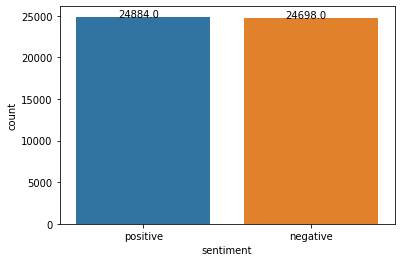

In [5]:
import seaborn as sns
ax = sns.countplot(cleaned_data['sentiment']);
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

#Result shows that, the dataset is imbalanced -positive reviews > negative reviews-
#Since the differance between +ve and -ve is 186, I would use under sampling method to solve this problem

In [6]:
X = cleaned_data['review'].values.reshape(-1, 1)
y = cleaned_data['sentiment']

#Do undersampling method to balance the data
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority')
X_sampled, y_sampled = undersample.fit_resample(X, y)
y_sampled.value_counts()

#notice; if we added 24698+24698+(difference 186) the total would be the orignal data after delete the duplicated rows

negative    24698
positive    24698
Name: sentiment, dtype: int64

In [7]:
#convert x_sampled and y_sampled into pandas series instead of numpy 2D-array
dataset = pd.DataFrame({'review': X_sampled.flatten(), 'sentiment': y_sampled}, columns=['review', 'sentiment'])
dataset.head()

review sentiment
0  Basically there's a family where a little boy ...  negative
1  This show was an amazing, fresh & innovative i...  negative
2  Encouraged by the positive comments about this...  negative
3  Phil the Alien is one of those quirky films wh...  negative
4  I saw this movie when I was about 12 when it c...  negative

#### (*) NLP Part: Prepare texts for modeling
1. Tokenize each word of every sentence in the dataset and also convert all character to lower case

2. Remove special characters and stop words

In [8]:
len(dataset['review'][0])

748

In [9]:
#remove special character code
dataset['review'] = dataset['review'].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
dataset['review'][0]

'Basically theres a family where a little boy Jake thinks theres a zombie in his closet  his parents are fighting all the timebr br This movie is slower than a soap opera and suddenly Jake decides to become Rambo and kill the zombiebr br OK first of all when youre going to make a film you must Decide if its a thriller or a drama As a drama the movie is watchable Parents are divorcing  arguing like in real life And then we have Jake with his closet which totally ruins all the film I expected to see a BOOGEYMAN similar movie and instead i watched a drama with some meaningless thriller spotsbr br 3 out of 10 just for the well playing parents  descent dialogs As for the shots with Jake just ignore them'

In [10]:
#remove stop word
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

corpus=[]
for text in dataset['review']:
    words = [word.lower() for word in word_tokenize(text) if word not in stopwords.words('english') and word not in 'br' and word not in 'i' and word not in 'the' and word not in 'it' and word not in 'this']
    corpus.append(words)

In [11]:
#get number of words in corpus
num_words = len(corpus)
num_words

49396

(*) Analysis of the dataset
1. #store +ve and -ve reviews in a different variables

In [12]:
#map dataset
a = {"review": corpus,"sentiment": dataset['sentiment']}
cleaned_dataset = pd.DataFrame(a)
cleaned_dataset.head()

review sentiment
0  [basically, theres, family, little, boy, jake,...  negative
1  [this, show, amazing, fresh, innovative, idea,...  negative
2  [encouraged, positive, comments, film, i, look...  negative
3  [phil, alien, one, quirky, films, humour, base...  negative
4  [i, saw, movie, i, 12, came, i, recall, scarie...  negative

In [13]:
#store +ve and -ve reviews in a different variables
positve_rev = cleaned_dataset.loc[cleaned_dataset['sentiment'] == 'positive']
positve_rev

review sentiment
24698  [reading, comments, message, boards, i, expect...  positive
24699  [opening, credits, great, music, right, film, ...  positive
24700  [saratoga, trunk, 1945, film, starring, ingrid...  positive
24701  [a, wonderfully, thoughtful, involving, movie,...  positive
24702  [pola, x, beautiful, adaption, herman, melvill...  positive
...                                                  ...       ...
49391  [i, fan, amandas, since, all, that, still, fun...  positive
49392  [i, film, dont, know, actually, put, scene, on...  positive
49393  [as, child, i, never, situation, i, could, int...  positive
49394  [this, story, australian, commandos, captured,...  positive
49395  [written, wind, douglas, sirks, melodrama, dou...  positive

[24698 rows x 2 columns]

In [14]:
negative_rev = cleaned_dataset.loc[cleaned_dataset['sentiment'] == 'negative']
negative_rev

review sentiment
0      [basically, theres, family, little, boy, jake,...  negative
1      [this, show, amazing, fresh, innovative, idea,...  negative
2      [encouraged, positive, comments, film, i, look...  negative
3      [phil, alien, one, quirky, films, humour, base...  negative
4      [i, saw, movie, i, 12, came, i, recall, scarie...  negative
...                                                  ...       ...
24693  [this, typical, junk, comedybr, there, almost,...  negative
24694  [bad, plot, bad, dialogue, bad, acting, idioti...  negative
24695  [i, catholic, taught, parochial, elementary, s...  negative
24696  [im, going, disagree, previous, comment, side,...  negative
24697  [no, one, expects, star, trek, movies, high, a...  negative

[24698 rows x 2 columns]

In [15]:
#now count frequency of words, iterate each row in the both variables
import itertools
positive_reviews_words = list(itertools.chain(*positve_rev['review']))
print("Total words in positive reviews:", len(positive_reviews_words))

negative_reviews_words = list(itertools.chain(*negative_rev['review']))
print("Total words in negative reviews:", len(negative_reviews_words))

Total words in positive reviews: 3263206
Total words in negative reviews: 3216548


In [16]:
#count the appearance of each word
import collections
positive_words_frequency = collections.Counter(positive_reviews_words)
#get the top 15 most frequent words in positive reviews
positive_words_freq_df = pd.DataFrame(positive_words_frequency.most_common(15), columns=["Word", "Frequency"])

negative_words_frequency = collections.Counter(negative_reviews_words)
#get the top 15 most frequent words in negative reviews
negative_words_freq_df = pd.DataFrame(negative_words_frequency.most_common(15), columns=["Word", "Frequency"])

In [17]:
#visualize the results
import matplotlib.pyplot as plt
# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
positive_words_freq_df.sort_values(by='Frequency').plot.bar(x="Word", y="Frequency", ax=ax, color='c')
# set the title
plt.title("Most Common words in positive reviews")
plt.show()

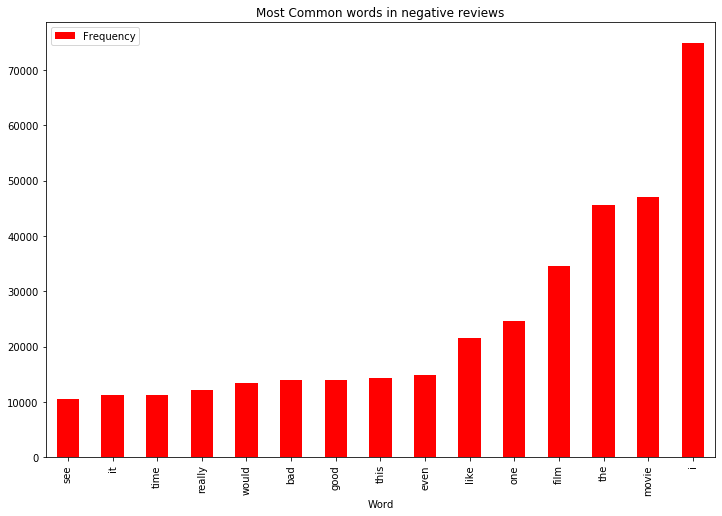

In [18]:
#visualize 
import matplotlib.pyplot as plt
# set figure size
fig, ax = plt.subplots(figsize=(12, 8))
# plot horizontal bar plot
negative_words_freq_df.sort_values(by='Frequency').plot.bar(x="Word", y="Frequency", ax=ax, color='r')
# set the title
plt.title("Most Common words in negative reviews")
plt.show()

In [19]:
#count the matching words that appearce in both variabels
count=0
for i in range(len(positive_words_freq_df)):
    for j in range(len(negative_words_freq_df)):
        if positive_words_freq_df['Word'][i] == negative_words_freq_df['Word'][j]:
            count+=1

In [20]:
count

11

In [21]:
# Split data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_dataset['review'], cleaned_dataset['sentiment'], stratify=cleaned_dataset['sentiment'], random_state=42, test_size=0.1, shuffle=True)

2. Tokenize words and use texts to sequences to transform each text to a sequence of intgers. Also, you must equlize all words to the same length using pad_sequences function

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=128, truncating='post', padding='post')

In [23]:
#do the same for test data
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=128, truncating='post', padding='post')

4. Convert label from string type to numbers using labelEncoder

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)
Y_test

array([0, 0, 1, ..., 1, 0, 1])

#### Create model using spiecal type of RNN algorithm (LSTM) and train it

In [25]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=100, input_length=128, trainable=True))
model.add(LSTM(100, dropout=0.1, return_sequences=True))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 100)          4939600   
                                                                 
 lstm (LSTM)                 (None, 128, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,100,501
Trainable params: 5,100,501
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=4, validation_data=(X_test, Y_test))

# Result shows (loss: 0.4471 - accuracy: 0.7908 - val_loss: 0.3578 - val_accuracy: 0.8466)
# Percentage of the model is 85%

Epoch 1/4
695/695 [==============================] - 278s 395ms/step - loss: 0.4191 - accuracy: 0.8015 - val_loss: 0.3277 - val_accuracy: 0.8727
Epoch 2/4
695/695 [==============================] - 270s 389ms/step - loss: 0.2067 - accuracy: 0.9259 - val_loss: 0.2989 - val_accuracy: 0.8781
Epoch 3/4
695/695 [==============================] - 288s 414ms/step - loss: 0.1290 - accuracy: 0.9582 - val_loss: 0.3627 - val_accuracy: 0.8553
Epoch 4/4
695/695 [==============================] - 257s 369ms/step - loss: 0.0964 - accuracy: 0.9705 - val_loss: 0.3836 - val_accuracy: 0.8711


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


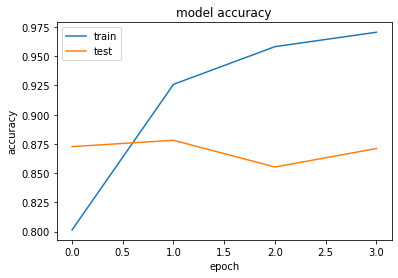

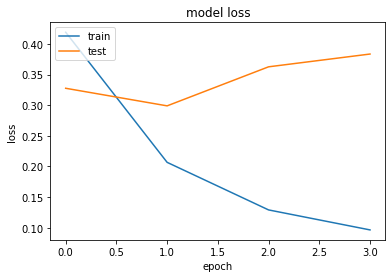

In [28]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
vs = ['The cast played Shakespeare.<br /><br />Shakespeare lost.<br /><br />I appreciate that this is trying to bring Shakespeare to the masses, but why ruin something so good.<br /><br />Is it because "The Scottish Play" is my favorite Shakespeare? I do not know. What I do know is that a certain Rev Bowdler (hence bowdlerization) tried to do something similar in the Victorian era.<br /><br />In other words, you cannot improve perfection.<br /><br />I have no more to write but as I have to write at least ten lines of text (and English composition was never my forte I will just have to keep going and say that this movie, as the saying goes, just does not cut it.']
vs_tokened = tokenizer.texts_to_sequences(vs)
vs_padded = pad_sequences(vs_tokened, maxlen=128, truncating='post', padding='post')
print(vs[0])
print('Result: {}'.format(model.predict(vs_padded)[0]))

The cast played Shakespeare.<br /><br />Shakespeare lost.<br /><br />I appreciate that this is trying to bring Shakespeare to the masses, but why ruin something so good.<br /><br />Is it because "The Scottish Play" is my favorite Shakespeare? I do not know. What I do know is that a certain Rev Bowdler (hence bowdlerization) tried to do something similar in the Victorian era.<br /><br />In other words, you cannot improve perfection.<br /><br />I have no more to write but as I have to write at least ten lines of text (and English composition was never my forte I will just have to keep going and say that this movie, as the saying goes, just does not cut it.
Result: [0.00559628]


In [41]:
IMDB_data2 = pd.read_csv("IMDB Dataset.csv")

x_train, x_test, y_train, y_test = train_test_split(IMDB_data2['review'], IMDB_data2['sentiment'], test_size=0.25, random_state=123)

In [42]:
x_train.shape, x_test.shape

((37500,), (12500,))

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()

In [44]:
x_train = cv.fit_transform(x_train)

In [45]:
x_test = cv.transform(x_test)

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 123)

In [48]:
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

In [50]:
y_pred = rf.predict(x_test)

In [51]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [52]:
accuracy_score(y_test,y_pred)

0.8384

In [54]:
print(confusion_matrix(y_test, y_pred))

[[5222 1006]
 [1014 5258]]
